## Preparación del entorno

In [4]:
# Importar bibliotecas necesarias para el análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

### Delitos en la Ciudad
El dataset utilizado en este análisis proviene del [Portal de Datos Abiertos del Gobierno de la Ciudad de Buenos Aires](https://data.buenosaires.gob.ar/dataset/delitos). El dataset abarca el período 2016-2023 Y los datos están organizados en archivos separados por año, donde cada archivo contiene la información de los delitos reportados en ese período específico. Los datos están disponibles bajo la licencia Creative Commons Attribution.

El dataset incluye las siguientes variables:

|Nombre|Tipo|Descripción|
|------|----|-----------|
|id-mapa o id-sum|integer|Identificador único.|
|anio|date|Año en el que se registró el evento.|
|mes|string|Mes en que ocurrió el evento.|
|dia|string|Día de la semana en que ocurrió el evento.|
|fecha|date|Fecha exacta del evento.|
|franja|integer|Franja horaria en la que ocurrió el evento.|
|tipo|string|Clasificación del tipo de delito.|
|subtipo|string|Subtipo del delito, más específico.|
|uso_arma|boolean|Indicador de uso de arma.|
|uso_moto|boolean|Indicador de uso de moto en el evento.|
|barrio|string|Barrio donde ocurrió el evento.|
|comuna|integer|Comuna donde ocurrió el evento.|
|latitud|float|Latitud geográfica donde ocurrió el evento.|
|longitud|float|Longitud geográfica donde ocurrió el evento.|
|cantidad|integer|Número de eventos registrados en esa ubicación y fecha.|

In [5]:
# Lista de archivos que hay que importar (delitos desde 2016 hasta 2023)
# Los archivos están almacenados en la misma carpeta que el notebook Jupyter
archivos_csv = [
    "delitos_2016.csv",
    "delitos_2017.csv",
    "delitos_2018.csv",
    "delitos_2019.csv",
    "delitos_2020.csv",
    "delitos_2021.csv",
    "delitos_2022.csv",
    "delitos_2023.csv"
]

# Crear lista para almacenar todos los data frames
dfs = []

# Importar los archivos de delitos uno por uno
for arch in archivos_csv:
    try:
        if arch != "delitos_2023.csv": #El arch de 2023 utiliza ";" como separadores, en lugar de ","
            df = pd.read_csv(arch)
        else:
            df = pd.read_csv(arch, sep=";")
        dfs.append(df)
    except FileNotFoundError:
        print(f"Advertencia: El archivo {arch} no fue encontrado y será omitido.")
    except Exception as e:
        print(f"Error al leer el archivo {arch}: {e}")

# Crear el data frame final de delitos si se cargaron datos
if dfs:
    df_delitos = pd.concat(dfs, ignore_index=True)
    print(f"Se cargaron {len(dfs)} archivos. Total de registros: {len(df_delitos)}")
    # Mostrar primeras filas del data frame de delitos
    display(df_delitos.head())
else:
    print("No se cargó ningún archivo de datos. Verifique la ruta y los nombres de los archivos.")
    # Crear un DataFrame vacío para evitar errores posteriores
    df_delitos = pd.DataFrame()

Se cargaron 8 archivos. Total de registros: 1097145


,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad,id-sum
0,500001.0,2016,ENERO,MARTES,2016-01-26,21.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.617668,-58.530961,1,NaN
1,500004.0,2016,ENERO,MIERCOLES,2016-01-20,16.0,Robo,Robo total,NO,NO,VILLA REAL,10.0,-34.620262,-58.530738,1,NaN
2,500007.0,2016,ENERO,DOMINGO,2016-01-03,13.0,Robo,Robo total,SI,NO,LINIERS,9.0,-34.640094,-58.529826,1,NaN
3,500010.0,2016,ENERO,SABADO,2016-01-09,17.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1,NaN
4,500013.0,2016,ENERO,LUNES,2016-01-25,18.0,Robo,Robo total,NO,NO,LINIERS,9.0,-34.640094,-58.529826,1,NaN


### Población de la Ciudad
Para calcular la métrica de "cantidad de delitos por 100.000 personas", es necesario conocer la población de la Ciudad de Buenos Aires a lo largo de los años. Esta información se obtuvo del Instituto de Estadística y Censos de la Ciudad Autónoma de Buenos Aires. Se puede encontrar la información en el siguiente enlace: [Población total estimada por sexo, superficie y densidad poblacional según comuna. Ciudad de Buenos Aires. Años 2006/2023](https://www.estadisticaciudad.gob.ar/eyc/?p=76599)

In [6]:
# Crear diccionario que va a almacenar la población de la Ciudad en cada año
poblacion_ciudad = {
    2016: 3059122,
    2017: 3063728,
    2018: 3068043,
    2019: 3072029,
    2020: 3075646,
    2021: 3078836,
    2022: 3081550,
    2023: 3083770
}

## Limpieza de datos

### Limpieza de columnas id-mapa y id-sum

In [7]:
# Algunos archivos utilizan "id-mapa" como id y otros utilizan "id-sum".
# Crear columna que almacene los ids de los delitos reportados
if 'id' not in df_delitos.columns:
    df_delitos['id'] = df_delitos['id-mapa'].fillna(df_delitos['id-sum'])

In [8]:
# Verificar que no halla ids faltantes
print(f"Ids faltantes: {df_delitos['id'].isna().sum()}")

Ids faltantes: 0


In [9]:
# Eliminar columnas "id-mapa" y "id-sum"
if 'id-mapa' in df_delitos.columns:
    df_delitos.drop('id-mapa', axis=1, inplace=True)
if 'id-sum' in df_delitos.columns:
    df_delitos.drop('id-sum', axis=1, inplace=True)

### Limpieza de la columna "anio":

In [10]:
# Verificar que los años son correctos
anios_invalidos = df_delitos[(df_delitos["anio"] < 2016) | (df_delitos["anio"] > 2023)]
print(f"cantidad de anios invalidos: {len(anios_invalidos)}")

cantidad de anios invalidos: 0


In [11]:
# Verificar el tipo de dato de la columna
print(f"tipo de dato: {df_delitos["anio"].dtype}")

tipo de dato: int64


In [12]:
# Convertir en un tipo de entero más pequeño
df_delitos["anio"] = df_delitos["anio"].astype("int16")
print(f"nuevo tipo de dato: {df_delitos["anio"].dtype}")

nuevo tipo de dato: int16


### Limpieza de la columna "mes":

In [13]:
# Verificar que los valores son válidos
print("meses:", end=" ")
for mes in df_delitos["mes"].unique():
    print(mes, end=" ")
print()

meses: ENERO FEBRERO MARZO ABRIL MAYO JUNIO JULIO AGOSTO SEPTIEMBRE OCTUBRE NOVIEMBRE DICIEMBRE 


In [14]:
# Verificar tipo de dato
print(f"tipo de dato: {df_delitos["mes"].dtype}")

tipo de dato: object


In [15]:
# Convertir a tipo de dato correcto
df_delitos["mes"] = df_delitos["mes"].astype("string")
print(f"nuevo tipo de dato: {df_delitos["mes"].dtype}")

nuevo tipo de dato: string


### Limpieza de la columna "dia":

In [59]:
# Verificar que los días de la semana sean válidos
print("dias de la semana:", end=" ")
for dia in df_delitos["dia"].unique():
    print(dia, end=" ")
print()

dias de la semana: MARTES MIERCOLES DOMINGO SABADO LUNES VIERNES JUEVES 


In [60]:
# Se detectó un error en los datos: Los días "SÁBADO" y "MIÉRCOLES" aparecen con y sin tilde
# Para solucionar esto, se normalizan los valores eliminado los tildes para mantener la consistencia
df_delitos.loc[df_delitos["dia"] == "SÁBADO", "dia"] = "SABADO"
df_delitos.loc[df_delitos["dia"] == "MIÉRCOLES", "dia"] = "MIERCOLES"

In [61]:
# Verificar los cambios
print("dias de la semana corregidos:", end=" ")
for dia in df_delitos["dia"].unique():
    print(dia, end=" ")
print()

dias de la semana corregidos: MARTES MIERCOLES DOMINGO SABADO LUNES VIERNES JUEVES 


In [62]:
# Asignar a los días de la semana un orden, ya que son valores categóricos ordinales
# Lista de días ordenados
dias_ordenados = ['LUNES', 'MARTES', 'MIERCOLES', 'JUEVES', 'VIERNES', 'SABADO', 'DOMINGO']

df_delitos['dia'] = pd.Categorical(df_delitos['dia'], 
                                        categories=dias_ordenados, 
                                        ordered=True)  

In [63]:
# Verificar el tipo de dato
print(f"tipo de dato: {df_delitos["dia"].dtype}")

tipo de dato: category


### Limpieza de la columna "fecha":

In [23]:
# Verificar el tipo de dato
print(f"tipo de dato: {df_delitos["fecha"].dtype}")

tipo de dato: object


In [24]:
# Convertir la columna fecha al tipo de dato correcto para facilitar el análisis
df_delitos["fecha"] = pd.to_datetime(df_delitos["fecha"], format="mixed", errors="coerce")
# Verificar si hubo errores en la conversión
errores_fecha = df_delitos["fecha"].isna().sum()
if errores_fecha > 0:
    print(f"Advertencia: {errores_fecha} fechas no se pudieron convertir y serán reemplazadas por NaT.")
# Convertir a tipo de dato correcto 
print(f"nuevo tipo de dato: {df_delitos["fecha"].dtype}")

nuevo tipo de dato: datetime64[ns]


In [25]:
# Verificar que las fechas esten en el rango correcto
fechas_invalidas = df_delitos[
    ~(df_delitos['fecha'].dt.year.between(2016, 2023))
]
print(f"cantidad de fechas fuera de rango: {len(fechas_invalidas)}")

cantidad de fechas fuera de rango: 0


### Limpieza de la columna "franja"

In [26]:
# Verificar que los valores son válidos (0-23)
franjas_invalidas = df_delitos[(df_delitos["franja"] < 0) | (df_delitos["franja"] > 23)]
print(f"cantidad de franjas invalidas: {len(franjas_invalidas)}")

cantidad de franjas invalidas: 0


In [27]:
# Verificar si hay valores faltantes
val_faltantes = df_delitos["franja"].isnull().sum()
print(val_faltantes)

2328


In [28]:
# Verificar tipo de dato
print(f"tipo de dato: {df_delitos["franja"].dtype}")

tipo de dato: float64


In [29]:
# Convertir al tipo de dato correcto
df_delitos["franja"] = df_delitos["franja"].astype("Int8")
print(f"nuevo tipo de dato: {df_delitos["franja"].dtype}")

nuevo tipo de dato: Int8


### Limpieza de la columna "tipo":

In [30]:
# Verificar que los valores sean válidos
print(f"tipos de delitos: {df_delitos["tipo"].unique()}")

tipos de delitos: ['Robo' 'Hurto' 'Vialidad' 'Homicidios' 'Amenazas' 'Lesiones']


In [31]:
# Verificar tipo de dato
print(f"tipo de dato: {df_delitos["tipo"].dtype}")

tipo de dato: object


In [32]:
# Convertir al tipo de dato correcto
df_delitos["tipo"] = df_delitos["tipo"].astype("string")
print(f"nuevo tipo de dato: {df_delitos["tipo"].dtype}")

nuevo tipo de dato: string


### Limpieza de la columna "subtipo":

In [33]:
# Verificar que los valores sean válidos
print(f"tipos de delitos: {df_delitos["subtipo"].unique()}")

tipos de delitos: ['Robo total' 'Robo automotor' 'Hurto automotor' 'Hurto total'
 'Lesiones por siniestros viales' 'Homicidios dolosos' 'Femicidios'
 'Amenazas' 'Lesiones Dolosas' 'Muertes por siniestros viales'
 'Homicidio Doloso']


In [34]:
# Hay dos valores, "Homicidios dolosos" y "Homicidio Doloso", que deberían ser uno solo

# Unificar las dos categorias
df_delitos["subtipo"] = df_delitos["subtipo"].replace("Homicidio Doloso", "Homicidios dolosos")

In [35]:
# Verificar cambios
print(f"tipos de delitos: {df_delitos["subtipo"].unique()}")

tipos de delitos: ['Robo total' 'Robo automotor' 'Hurto automotor' 'Hurto total'
 'Lesiones por siniestros viales' 'Homicidios dolosos' 'Femicidios'
 'Amenazas' 'Lesiones Dolosas' 'Muertes por siniestros viales']


In [36]:
# Verificar tipo de dato
print(f"tipo de dato: {df_delitos["subtipo"].dtype}")

tipo de dato: object


In [37]:
# Convertir al tipo de dato correcto
df_delitos["subtipo"] = df_delitos["subtipo"].astype("string")
print(f"nuevo tipo de dato: {df_delitos["subtipo"].dtype}")

nuevo tipo de dato: string


### Limpieza de la columna "uso_arma":

In [38]:
# Verificar si hay valores faltantes
print(f"cantidad de faltantes en 'uso_arma': {df_delitos["uso_arma"].isna().sum()}")

cantidad de faltantes en 'uso_arma': 0


In [39]:
# Convertir columnas 'uso_arma' y 'uso_moto' de SI/NO a valores booleanos
# para facilitar el análisis
bool_conversion = {"SI": True, "NO": False}
df_delitos["uso_arma"] = df_delitos["uso_arma"].apply(lambda x: bool_conversion.get(x, x))

In [40]:
# Verifico los cambios
print(f"valores en 'uso_arma': {df_delitos["uso_arma"].unique()}")

valores en 'uso_arma': [False  True]


In [41]:
# Verifico el tipo de dato
print(f"tipo de dato: {df_delitos["uso_arma"].dtype}")

tipo de dato: bool


### Limpieza de la columna "uso_moto":

In [42]:
# Verificar si hay valores faltantes
print(f"cantidad de faltantes en 'uso_moto': {df_delitos["uso_moto"].isna().sum()}")

cantidad de faltantes en 'uso_moto': 0


In [43]:
# Convertir columnas 'uso_arma' y 'uso_moto' de SI/NO a valores booleanos
# para facilitar el análisis
bool_conversion = {"SI": True, "NO": False}
df_delitos["uso_moto"] = df_delitos["uso_moto"].apply(lambda x: bool_conversion.get(x, x))

In [44]:
# Verifico los cambios
print(f"valores en 'uso_arma': {df_delitos["uso_moto"].unique()}")

valores en 'uso_arma': [False  True]


In [45]:
# Verifico el tipo de dato
print(f"tipo de dato: {df_delitos["uso_moto"].dtype}")

tipo de dato: bool


### Limpieza de la columna barrio

In [46]:
# Asegurar que 'barrio' sea de tipo string
if not df_delitos.empty and 'barrio' in df_delitos.columns:
    print(f"Tipo de dato original 'barrio': {df_delitos['barrio'].dtype}")
    if df_delitos['barrio'].dtype != 'string':
        df_delitos["barrio"] = df_delitos["barrio"].astype("string")
    print(f"Nuevo tipo de dato 'barrio': {df_delitos['barrio'].dtype}")
    print(f"Valores faltantes en 'barrio': {df_delitos['barrio'].isna().sum()}")

Tipo de dato original 'barrio': object
Nuevo tipo de dato 'barrio': string
Valores faltantes en 'barrio': 25583


### Limpieza de la columna "comuna":

In [47]:
# Estandarizar valores de 'comuna'
if not df_delitos.empty and 'comuna' in df_delitos.columns:
    print(f"Valores originales en 'comuna': {df_delitos['comuna'].unique()}")

    # Diccionario con correcciones básicas
    dict_correciones = {
        "CC-01 NORTE": 1,
        "CC-01 SUR": 1,
        "CC-02": 2,
        "CC-03": 3,
        "CC-04": 4,
        "CC-05": 5,
        "CC-06": 6,
        "CC-07": 7,
        "CC-08": 8,
        "CC-09": 9,
        "CC-10": 10,
        "CC-11": 11,
        "CC-12": 12,
        "CC-13": 13,
        "CC-14": 14,
        "CC-15": 15,
        "Sin geo": np.nan # Marcar 'Sin geo' como NaN
    }

    # Aplicar correcciones y convertir a numérico (errores a NaN)
    df_delitos["comuna"] = df_delitos["comuna"].replace(dict_correciones)
    df_delitos["comuna"] = pd.to_numeric(df_delitos["comuna"], errors='coerce')

    print(f"Valores estandarizados (antes de tipo Int8): {df_delitos['comuna'].unique()}")

    # Convertir a tipo Int8 (entero nullable)
    print(f"Tipo de dato original 'comuna': {df_delitos['comuna'].dtype}")
    df_delitos["comuna"] = df_delitos["comuna"].astype("Int8")
    print(f"Nuevo tipo de dato 'comuna': {df_delitos['comuna'].dtype}")
    print(f"Valores faltantes en 'comuna': {df_delitos['comuna'].isna().sum()}")

Valores originales en 'comuna': [10.0 9.0 11.0 12.0 15.0 7.0 8.0 13.0 6.0 14.0 5.0 4.0 nan 2.0 3.0 1.0
 '13' '8' '12' '7' '3' '2' '10' '4' '15' '9' '14' '1' '11' '5' '6' 'CC-08'
 'CC-09' 'CC-01 NORTE' 'CC-04' 'CC-07' 'CC-15' 'CC-02' 'CC-12' 'CC-10'
 'CC-06' 'CC-13' 'CC-05' 'CC-01 SUR' 'CC-03' 'CC-14' 'Sin geo' 'CC-11']
Valores estandarizados (antes de tipo Int8): [10.  9. 11. 12. 15.  7.  8. 13.  6. 14.  5.  4. nan  2.  3.  1.]
Tipo de dato original 'comuna': float64
Nuevo tipo de dato 'comuna': Int8
Valores faltantes en 'comuna': 25917


### Limpieza de las columnas "latitud" y "longitud"

In [48]:
# Asegurar que latitud y longitud sean de tipo float
if not df_delitos.empty:
    for col in ['latitud', 'longitud']:
        if col in df_delitos.columns:
            print(f"Tipo de dato original '{col}': {df_delitos[col].dtype}")
            # Convertir a numérico, tratando errores
            df_delitos[col] = pd.to_numeric(df_delitos[col], errors='coerce')
            # No es necesario convertir a float explícitamente si to_numeric ya lo hizo
            # df_delitos[col] = df_delitos[col].astype(float)
            print(f"Nuevo tipo de dato '{col}': {df_delitos[col].dtype}")
            print(f"Valores faltantes en '{col}': {df_delitos[col].isna().sum()}")

Tipo de dato original 'latitud': object
Nuevo tipo de dato 'latitud': float64
Valores faltantes en 'latitud': 160393
Tipo de dato original 'longitud': object
Nuevo tipo de dato 'longitud': float64
Valores faltantes en 'longitud': 160383


### Limpieza de la columna "cantidad"

In [49]:
# Asegurar que 'cantidad' sea de tipo entero
if not df_delitos.empty and 'cantidad' in df_delitos.columns:
    print(f"Tipo de dato original 'cantidad': {df_delitos['cantidad'].dtype}")
    # Convertir a numérico primero, tratando errores
    df_delitos["cantidad"] = pd.to_numeric(df_delitos["cantidad"], errors='coerce')

    # Verificar valores faltantes (incluye los que no se pudieron convertir)
    print(f"Valores faltantes en 'cantidad' (antes de Int): {df_delitos['cantidad'].isna().sum()}")

    # Convertir a tipo Int16 (entero nullable)
    df_delitos["cantidad"] = df_delitos["cantidad"].astype("Int16")
    print(f"Nuevo tipo de dato 'cantidad': {df_delitos['cantidad'].dtype}")
    print(f"Valores faltantes en 'cantidad' (después de Int): {df_delitos['cantidad'].isna().sum()}")

Tipo de dato original 'cantidad': int64
Valores faltantes en 'cantidad' (antes de Int): 0
Nuevo tipo de dato 'cantidad': Int16
Valores faltantes en 'cantidad' (después de Int): 0


### Limpieza de duplicados

In [50]:
# Hallar si hay registros duplicados completos
if not df_delitos.empty:
    duplicados = df_delitos.duplicated().sum()
    print(f"Número de filas duplicadas: {duplicados}")
    # Opcional: eliminar duplicados si se desea
    # df_delitos = df_delitos.drop_duplicates()

Número de filas duplicadas: 0


### Tipos de dato final 

In [51]:
# Ver el tipo de dato final de todas las columnas
if not df_delitos.empty:
    print("\nTipos de datos finales de las columnas:")
    display(df_delitos.dtypes)


Tipos de datos finales de las columnas:


anio                 int16
mes         string[python]
dia         string[python]
fecha       datetime64[ns]
franja                Int8
tipo        string[python]
subtipo     string[python]
uso_arma              bool
uso_moto              bool
barrio      string[python]
comuna                Int8
latitud            float64
longitud           float64
cantidad             Int16
id                 float64
dtype: object

### Mostrar información del DataFrame final

In [52]:
# Mostrar información general del DataFrame limpio
if not df_delitos.empty:
    print("\nInformación general del DataFrame:")
    df_delitos.info()


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097145 entries, 0 to 1097144
Data columns (total 15 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   anio      1097145 non-null  int16         
 1   mes       1097145 non-null  string        
 2   dia       1097145 non-null  string        
 3   fecha     1097145 non-null  datetime64[ns]
 4   franja    1094817 non-null  Int8          
 5   tipo      1097145 non-null  string        
 6   subtipo   1097145 non-null  string        
 7   uso_arma  1097145 non-null  bool          
 8   uso_moto  1097145 non-null  bool          
 9   barrio    1071562 non-null  string        
 10  comuna    1071228 non-null  Int8          
 11  latitud   936752 non-null   float64       
 12  longitud  936762 non-null   float64       
 13  cantidad  1097145 non-null  Int16         
 14  id        1097145 non-null  float64       
dtypes: Int16(1), Int8(2), bool(2),

## Filtrado de datos

### Filtrado por tipo de delito

Para enfocar el análisis en los horarios de robos y hurtos, se filtrará el DataFrame para conservar únicamente los registros correspondientes a los tipos de delito "Robo" y "Hurto".

In [53]:
# Filtrar el DataFrame para incluir solo "robo" y "hurto"
if not df_delitos.empty:
    tipos_deseados = ['Robo', 'Hurto']
    df_robos_hurtos = df_delitos[df_delitos['tipo'].isin(tipos_deseados)].copy() # Usar .copy() para evitar SettingWithCopyWarning

    print(f"Registros antes del filtrado: {len(df_delitos)}")
    print(f"Registros después del filtrado (Robo/Hurto): {len(df_robos_hurtos )}")

    # Mostrar los valores únicos en la columna 'tipo' del DataFrame filtrado
    if not df_robos_hurtos.empty:
        print("\nValores únicos en la columna 'tipo' después del filtrado:")
        print(df_robos_hurtos['tipo'].unique())
    else:
        print("El DataFrame filtrado está vacío.")

else:
    print("El DataFrame original está vacío, no se puede filtrar.")
    df_robos_hurtos = pd.DataFrame() # Crear DataFrame vacío si el original lo era

Registros antes del filtrado: 1097145
Registros después del filtrado (Robo/Hurto): 833544

Valores únicos en la columna 'tipo' después del filtrado:
<StringArray>
['Robo', 'Hurto']
Length: 2, dtype: string


## Análisis Exploratorio General

Antes de profundizar, es útil realizar un análisis exploratorio general para entender los datos

### Frecuencia de tipos de delitos

Esto nos ayuda a ver cuántos robos y hurtos hay en comparación con otros tipos

In [54]:
print(df_delitos['tipo'].value_counts())

tipo
Robo          474356
Hurto         359188
Lesiones      107683
Amenazas       81051
Vialidad       73926
Homicidios       941
Name: count, dtype: Int64


In [56]:
# Calcular proporciones
frecuencia_tipos = df_delitos['tipo'].value_counts()

total_delitos = sum(frecuencia_tipos.values)
proporciones = {k: (v / total_delitos) * 100 for k, v in frecuencia_tipos.items()}

# Mostrar proporciones
for tipo, porcentaje in proporciones.items():
    print(f"{tipo}: {porcentaje:.2f}%")

Robo: 43.24%
Hurto: 32.74%
Lesiones: 9.81%
Amenazas: 7.39%
Vialidad: 6.74%
Homicidios: 0.09%


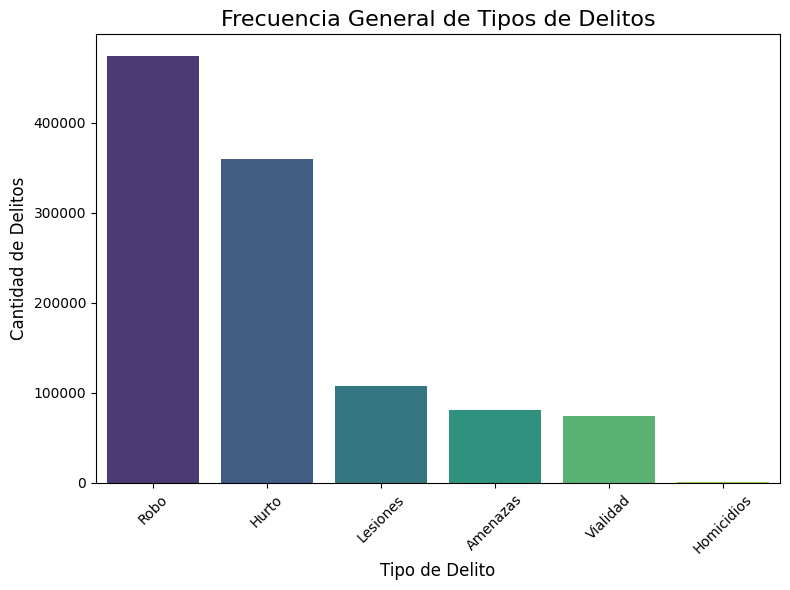

In [57]:
# Gráfico de barras de frecuencia de tipos de delitos
frecuencia_tipos = df_delitos['tipo'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=frecuencia_tipos.index, 
            y=frecuencia_tipos.values, 
            hue=frecuencia_tipos.index, 
            palette="viridis",
            legend=False )
plt.title("Frecuencia General de Tipos de Delitos", fontsize=16)
plt.xlabel("Tipo de Delito", fontsize=12)
plt.ylabel("Cantidad de Delitos", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Observaciones:
Los **robos y hurtos** representan el **75.98% de los delitos** denunciados en total.

### Distribución por franjas horarias

Verifico cuántos delitos hay en cada franja horaria.

In [52]:
print(df_robos_hurtos['franja'].value_counts().sort_index())

franja
0     39381
1     17486
2     14099
3     13012
4     13101
5     17048
6     22513
7     30685
8     36493
9     34556
10    36878
11    35247
12    42691
13    38755
14    40820
15    40230
16    41246
17    44089
18    49526
19    50810
20    52098
21    46033
22    41012
23    33661
Name: count, dtype: Int64


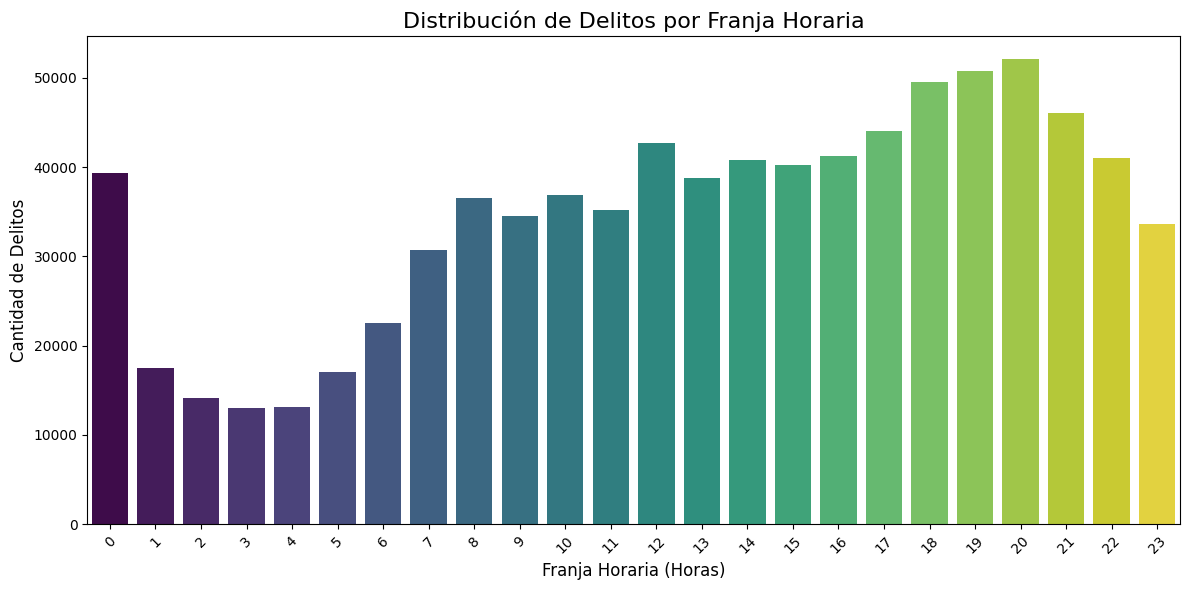

In [63]:
# Gráfico de barras de frecuencia por franjas horarias
frecuencia_horaria = df_robos_hurtos['franja'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=frecuencia_horaria.index, 
            y=frecuencia_horaria.values, 
            palette="viridis", 
            hue=frecuencia_horaria.index, 
            legend=False)
plt.title("Distribución de Delitos por Franja Horaria", fontsize=16)
plt.xlabel("Franja Horaria (Horas)", fontsize=12)
plt.ylabel("Cantidad de Delitos", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Observaciones:
- Las franjas horarias con **mayor cantidad de delitos** son:
    - 20:00 horas: 52,098 casos (pico máximo).
    - 19:00 horas: 50,810 casos.
    - 18:00 horas: 49,526 casos.
- Las franjas horarias con **menor cantidad de delitos** son:
    - 3:00 horas: 13,012 casos (pico mínimo).
    - 4:00 horas: 13,101 casos.
    - 2:00 horas: 14,099 casos.
- A partir de las **5:00 horas**, los robos y hurtos comienzan a **aumentar de manera significativa**. Este crecimiento continúa hasta las **8:00 horas**.


### Distribución por días de la semana

Verifico cuántos delitos relacionados con los robos y hurtos suceden por día de la semana

In [53]:
print(df_robos_hurtos['dia'].value_counts())

dia
VIERNES      127848
MIERCOLES    124887
JUEVES       123763
MARTES       122787
LUNES        122227
SABADO       114346
DOMINGO       97686
Name: count, dtype: Int64


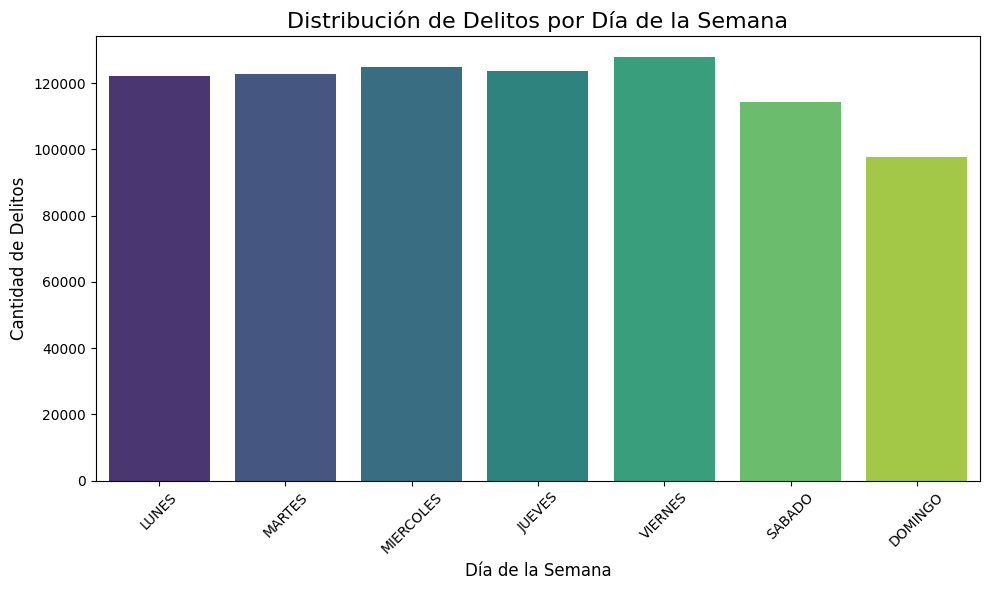

In [65]:
# Gráfico de barras de frecuencia de robos y hurtos por días de la semana
frecuencia_dias = df_robos_hurtos['dia'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencia_dias.index, 
            y=frecuencia_dias.values, 
            hue=frecuencia_dias.index,
            palette="viridis",
            legend=False)
plt.title("Distribución de Delitos por Día de la Semana", fontsize=16)
plt.xlabel("Día de la Semana", fontsize=12)
plt.ylabel("Cantidad de Delitos", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()